# Stochastic Volatility Inspired Model
------------------
> **Idriss Afra**

This project aims to fit the Equity implied volatility surface under the Stochastic Volatility Inspired (SVI) model.

## The SVI Parameterization

The SVI model is a parametric formulation that uses five parameters for each listed expiry $T$, denoted by $\Gamma_T := \{a, b, \rho, m, \sigma\}$. It models the implied total variance as a function of log-moneyness $k$ using the following equation:

$$
\omega(k, \Gamma_T) = \sigma_{Imp}^{2}(k, \Gamma_T)\, T
= a + b \left[\rho (k - m) + \sqrt{(k-m)^2 + \sigma^2} \right]
$$

Where:

$$
k := \ln \left( \frac{K}{F_T} \right) \in \mathbb{R}, \quad a \in \mathbb{R}, \quad b \ge 0, \quad |\rho| < 1, \quad m \in \mathbb{R}, \quad \sigma > 0,
$$

The five SVI parameters influence the shape of the implied total variance curve in the following ways:
* $a$ : Sets the overall level of total variance. Increasing $a$ shifts the entire skew upward, raising the general variance level.
* $b$ : Controls the average steepness of the wings. A higher $b$ makes the wings steeper.
* $\rho$ : Determines the orientation / asymmetry of the skew. Increasing $\rho$ rotates the smile counter-clockwise.
* $m$ : Shifts the skew horizontally. A higher $m$ moves the smile to the right.
* $\sigma$ : Controls the local curvature scale near the minimum. Increasing $\sigma$ typically flattens the center region of the smile.

These parameters allow the SVI model to flexibly capture the typical shapes observed in implied volatility surfaces.

---
## The Butterfly Arbitrage

To ensure the absence of butterfly arbitrage under the SVI model, the risk-neutral probability density function of the terminal asset price $S_T$ must remain non-negative:

$$
f_{S_T}(K) = e^{rT}\, \frac{d^2 C(K,T)}{dK^2} \ge 0
$$

In the Black-Scholes framework written in terms of log-moneyness $k=\ln(K/F_T)$ and total variance $\omega(k)$, call prices can be expressed as:

$$
C_{BS}(k, \omega(k, \Gamma_T)) = S e^{-qT}\left(N(d_1) - e^k N(d_2)\right)
$$

With:

$$
d_1 = \frac{-k + \omega(k,\Gamma_T)/2}{\sqrt{\omega(k,\Gamma_T)}}
\qquad
d_2 = d_1 - \sqrt{\omega(k,\Gamma_T)}
$$

By differentiating the Black-Scholes call price twice with respect to strike (equivalently, with respect to $k$ via the chain rule), one obtains:

$$
p(k) := \frac{d^2 C_{BS}(k, \omega(k, \Gamma_T))}{dK^2}
= \frac{g(k)}{\sqrt{2\pi\,\omega(k,\Gamma_T)}} \exp\!\left(-\frac{d_2^2}{2}\right)
$$

Where:

$$
g(k) := \left(1- \frac{k\,\omega'(k, \Gamma_T)}{2\,\omega(k, \Gamma_T)}\right)^2
- \frac{\omega'(k, \Gamma_T)^2}{4}\left( \frac{1}{\omega(k, \Gamma_T)} + \frac{1}{4}\right)
+ \frac{\omega''(k, \Gamma_T)}{2}
$$

<br>Therefore, the butterfly free-arbitrage condition is: $ g(k) \ge 0 \quad \text{for all } k \in \mathbb{R}. $

In this project, we verify that this inequality holds on a dense grid of moneyness values ranging from $0.01\%$ to $200\%$ (in moneyness terms), i.e. $k \in [\ln(0.0001), \ln(2)]$, augmented by the market grid points.

---
## Volatility on the Wings

To guarantee the absence of butterfly arbitrage, special attention must be given to the wings of the volatility skew. Specifically, we need to make sure that the function $g(k)$ remains non-negative for extreme strike values.

Since:
* For ${k \to +\infty}$ : $ \omega_R(k, \Gamma_T) \approx b(\rho + 1)k + \big[a-bm(\rho + 1)\big] $

* For ${k \to -\infty}$ : $ \omega_L(k, \Gamma_T) \approx b(\rho - 1)k + \big[a-bm(\rho - 1)\big] $

Then for extreme strikes, $g(k)$ can be approximated by a quadratic polynomial in $k$:
$$
g(k) \approx \frac{\beta^2}{4} \left(1 - \frac{\beta^2}{4}\right) k^2 + \frac{1}{4} \left(4\alpha\beta - \beta^3 - \frac{\alpha\beta^3}{2}\right) k + \frac{1}{4} \left(4\alpha^2 - \alpha\beta^2 - \frac{\alpha^2\beta^2}{4}\right)
$$
Where:
* For ${k \to +\infty}$ : $\alpha=a - bm(\rho + 1)$ and $\beta=b(\rho + 1)$

* For ${k \to -\infty}$ : $\alpha=a - bm(\rho - 1)$ and $\beta=b(\rho - 1)$

We avoid wing-driven butterfly arbitrages by requiring that:
* the quadratic coefficient is positive, which implies $0<\beta^2<4$, and
* the discriminants $Δ_R$ and $Δ_L$ are negative (so the quadratic stays positive).

These conditions lead to the following constraints:

* Constraint 1 : $ (a-mb(\rho+1))(4-a+mb(\rho+1))-b^2(\rho+1)^2 > 0 $

* Constraint 2 : $ (a-mb(\rho-1))(4-a+mb(\rho-1))-b^2(\rho-1)^2 > 0 $

* Constraint 3 : $ b(\rho+1) < 2 $

* Constraint 4 : $ b(1-\rho) < 2 $

---
## The Calendar Arbitrage

To ensure the absence of calendar spread arbitrage under the SVI model, we must impose for each $k$ that total variance is non-decreasing in expiry: $ \omega(k, \Gamma_{T_i}) \ge \omega(k, \Gamma_{T_{i-1}}) \quad \text{for all } k.$

In this project, we verify that this inequality holds on a dense grid of moneyness values ranging from $0.01\%$ to $200\%$ (in moneyness terms), i.e. $k \in [\ln(0.0001), \ln(2)]$, augmented by the market grid points.

---
## SVI Model Calibration

The calibration of the SVI model goes through a constrained minimization process to replicate the market-implied volatilities (slice by slice).

Hence, for each market expiry $T$ we solve:

$$
\Gamma_T^{*} = \arg\min_{\Gamma_T} \frac{1}{N_T} \sum_{i=1}^{N_T}\left(\sigma_{SVI}(k_i,T;\Gamma_T) - \sigma_{i,T}^{Market}\right)^{2}
$$

where: $ \sigma_{SVI}(k_i,T;\Gamma_T)=\sqrt{\frac{\omega(k_i,\Gamma_T)}{T}} $

---
## SVI Parameters Boundaries

To ensure an efficient calibration of the SVI model that respects the model's conditions and avoids arbitrages, we establish practical boundaries for each parameter:

* Parameter $a$: 
The minimum of the SVI total variance occurs at the point $ k^* = m - \frac{\rho \sigma}{\sqrt{1 - \rho^2}}$, and its value is $\omega_{\min} = a + b \sigma \sqrt{1 - \rho^2}.$
A necessary condition for non-negative variance is $a + b \sigma \sqrt{1 - \rho^2} \ge 0.$
<br>In the implementation, rather than forcing $a>0$, we allow $a$ to be negative but bounded relative to observed market total variance $-\max(\omega^{market}) \le a \le 2\max(\omega^{market}).$

* Parameter $\rho$: The correlation coefficient must lie in $-0.99 \le \rho \le 0.99.$

* Parameter $m$: This parameter controls the horizontal translation of the skew. In the implementation, it is bounded using the market log-moneyness range $\min(k^{market}) - 0.5 \le m \le \max(k^{market}) + 0.5.$

* Parameter $\sigma$: To ensure stable curvature near the minimum and avoid degenerate shapes, the implementation uses $10^{-6} \le \sigma \le 2.$

* Parameter $b$: Since $b\ge 0$ and wing slopes must remain controlled, the implementation uses $10^{-8} \le b \le 5.$

These bounds, along with the above constraints, improve numerical stability and guide the optimizer toward reasonable regions of the parameter space while preserving the arbitrage checks implemented in the calibration routine.

---
## Smart Initial Guess

For each maturity slice $(k_T,\omega_T)$, the optimizer requires a reasonable starting point $\Gamma_T^{(0)}=(a_0,b_0,\rho_0,m_0,\sigma_0)$.

For the first listed expiry, we initialize the optimizer using the smart initial guess below:

### Wing slopes $(b_0,\rho_0)$

Since:

* as $k\to +\infty$: $\omega(k)\approx b(\rho+1)k + \big[a-bm(\rho+1)\big] \quad \Rightarrow \quad \beta_R \approx b(\rho+1)$

* as $k\to -\infty$: $\omega(k)\approx b(\rho-1)k + \big[a-bm(\rho-1)\big] \quad \Rightarrow \quad \beta_L \approx b(\rho-1)$

Therefore: 
$$b_{0} \approx \frac{\beta_R-\beta_L}{2}, \qquad \rho_{0} \approx \frac{\beta_R+\beta_L}{\beta_R-\beta_L}.$$

The code fits $\beta_L,\beta_R$ by least squares on the left and right wings.

### Local quadratic at the minimum $(\sigma_0,m_0,a_0)$

Let $k_i=\arg\min_j \omega_j$ (usually the ATM region). Over a small window around $k_i$, the code fits: $\omega(k)\approx c_0+c_1x+c_2x^2$, with $x=k-k_i$.

This provides:
* Curvature estimate: $\ \omega''(k^{*})\approx 2c_2$,
* Refined minimum value estimate: $\omega(k^{*})\approx c_0+c_1(k^{*} - k_i)+c_2(k^{*} - k_i)^2$,
* Refined minimizer estimate:  $\omega'(k^{*}) \approx 0 \Rightarrow x^{*}=-\frac{c_1}{2c_2} \Rightarrow k^{*}\approx k_i-\frac{c_1}{2c_2}$

Raw SVI derivatives are:
$$
\omega'(k)=b\left(\rho+\frac{k-m}{\sqrt{(k-m)^2+\sigma^2}}\right),
\qquad
\omega''(k)=b\,\frac{\sigma^2}{\left((k-m)^2+\sigma^2\right)^{3/2}}.
$$

At the minimum $k^{*}$, $\omega'(k^{*})=0$ implies
$\ (k^{*}-m)^2+\sigma^2=\sigma^2/(1-\rho^2)$, hence the key identity:
$$
\omega''(k^{*})=\frac{b(1-\rho^2)^{3/2}}{\sigma}
\quad\Rightarrow\quad
\sigma_{0}=\frac{b(1-\rho^2)^{3/2}}{2c_{2}}.
$$

We then use the raw-SVI minimum identities:
$$
k^{*} = m - \frac{\rho\sigma}{\sqrt{1-\rho^2}}
\Rightarrow
m_0 = k_i-\frac{c_1}{2c_2} + \frac{\rho_0\sigma_0}{\sqrt{1-\rho_0^2}},
$$
and
$$
\omega^{*} = a + b\sigma\sqrt{1-\rho^2}
\Rightarrow
a_0 = c_0+c_1(k^{*} - k_i)+c_2(k^{*} - k_i)^2 - b_0\sigma_0\sqrt{1-\rho_0^2}.
$$

For each subsequent expiry, we warm-start the optimizer using the calibrated parameters from the previous expiry as the initial guess.

---
## SVI Model Implementation

In [1]:
# Required Libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import PchipInterpolator

# For printing purposes
import warnings
warnings.filterwarnings("ignore")

class SVIModel:
    """
    The SVI model class.
    """
    def __init__(self):
        """
        Init method.
        """
        self.params = {}

    def _g(self, T, k, params, floor=1e-12) :
        """
        The g function under the SVI model.
        The log-moneyness k can be a scalar or an array.
        /!\ For internal use only /!\
        """
        b, rho, m, sigma = params[1], params[2], params[3], params[4]
        v2T = np.maximum(self._v2T(T, k, params), floor)
        dv2T_dk = b * (rho + (k - m) / np.sqrt((k - m)**2 + sigma**2))
        d2v2T_dk2 = b * (sigma**2) / (((k - m)**2 + sigma**2)**(3/2))
        return (1 - (k * dv2T_dk) / (2 * v2T))**2 - (dv2T_dk**2) / 4 * (1 / v2T + 1 / 4) + d2v2T_dk2 / 2

    def _v2T(self, T, k, params=None) :
        """
        V2T formula under the SVI model.
        The log-moneyness k can be a scalar or an array.
        /!\ For internal use only /!\
        """
        if params is None: 
            key = round(T, 12)
            params = self.params[key]
        a, b, rho, m, sigma = params[0], params[1], params[2], params[3], params[4]
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma **2))

    def params_calibration(self, T, k, v2T, maxiter=4000, tol=1e-8):
        """
        SVI model calibration : The method returns the calibrated SVI total variances.
        T is an array of listed options expiries.
        The constraints ensure the Calendar and the Butterfly arbitrages-free.
        """
        # Sanity checks
        if not isinstance(T, (list, np.ndarray)) or len(T) == 0:
            raise TypeError("T must be a non-empty list or array of expiries.")
        if np.any(np.diff(np.asarray(T, float)) <= 0):
            raise ValueError("Expiries T must be strictly increasing.")
        if not isinstance(k, (list, np.ndarray)) or len(k) == 0:
            raise TypeError("k must be a non-empty list or array of log-moneynesses per expiry.")
        if not isinstance(v2T, (list, np.ndarray)) or len(v2T) == 0:
            raise TypeError("v2T must be a non-empty list or array of total variances per expiry.")
        if len(T) != len(k) or len(T) != len(v2T):
            raise ValueError("T, k, and v2T must have equal lengths.")
        if not isinstance(maxiter, int) or maxiter <= 0:
            raise ValueError("maxiter must be a positive integer.")
        if not isinstance(tol, (float, np.number)) or tol <= 0:
            raise ValueError("tol must be a positive number.")
        # SVI calibration process
        print("Starting the SVI calibration process...\n")
        results = {}
        # SVI calibration on the first expiry
        parameters0 = self.svi_smart_initial_guess(k[0], v2T[0])
        constraints = ({'type': 'ineq', 'fun':self._constraint1}, {'type': 'ineq', 'fun':self._constraint2}, 
                       {'type': 'ineq', 'fun':self._constraint3}, {'type': 'ineq', 'fun':self._constraint4},
                       {'type': 'ineq', 'fun':self._constraint5, 'args': (T[0], k[0])})
        res = self._fit_slice(T[0], k[0], v2T[0], parameters0, constraints, maxiter, tol)
        key = round(T[0], 12)
        results[key] = res.x
        a, b, rho, m, sigma = res.x
        print(
            f"    T = {T[0]:7.4f} : "
            f"a = {a: .4f}  b = {b: .4f}  rho = {rho: .4f}  m = {m: .4f}  sigma = {sigma: .4f}"
        )
        for i in range(1, len(T)):
            # SVI calibration on the next expiries
            T_previous = T[i-1]
            k_previous = k[i-1]
            key_prev = round(T[i-1], 12)
            params_previous = results[key_prev]
            parameters0 = results[key_prev].copy()
            constraints = ({'type': 'ineq', 'fun':self._constraint1}, {'type': 'ineq', 'fun':self._constraint2}, 
                           {'type': 'ineq', 'fun':self._constraint3}, {'type': 'ineq', 'fun':self._constraint4},
                           {'type': 'ineq', 'fun':self._constraint5, 'args': (T[i], k[i])},
                           {'type': 'ineq', 'fun':self._constraint6, 'args': (T[i], T_previous, k[i], 
                                                                              k_previous, params_previous)})
            res = self._fit_slice(T[i], k[i], v2T[i], parameters0, constraints, maxiter, tol)
            if res.success == True : 
                # Successful calibration
                key = round(T[i], 12)
                results[key] = res.x
                a, b, rho, m, sigma = res.x
                print(
                    f"    T = {T[i]:7.4f} : "
                    f"a = {a: .4f}  b = {b: .4f}  rho = {rho: .4f}  m = {m: .4f}  sigma = {sigma: .4f}"
                )
            else :
                # We ignore the listed expiries on which the calibration has failed
                print(f"/!\ Expiry {round(T[i], 4)} will be ignored as it's causing arbitrages on the wings.\n")
        self.params = results

    def svi_smart_initial_guess(self, k, w, tail_frac=0.2):
        """
        Smart initial guess for the SVI parameters: [a, b, rho, m, sigma].
        """
        # Sanity checks
        if not isinstance(k, (list, np.ndarray)) or len(k) == 0:
            raise TypeError("k must be a non-empty list or array of log-moneynesses.")
        if not isinstance(w, (list, np.ndarray)) or len(w) == 0:
            raise TypeError("w must be a non-empty list or array of total variances.")
        if len(k) != len(w):
            raise ValueError("k and w must have equal lengths.")
        # Initial guess computation
        k = np.asarray(k, float)
        w = np.asarray(w, float)
        k_idx_sort = np.argsort(k)
        k, w = k[k_idx_sort], np.maximum(w[k_idx_sort], 1e-12)
        n = len(k)
        if n < 6:
            # Not enough points for a proper initial guess -> use arbitrary, yet reasonable, values
            i = int(np.argmin(w)) # ~ ATM point 
            return np.array([max(1e-8, w[i]*0.5), 0.5, -0.2, k[i], 0.2])
        # A- wing slopes via simple least squares to get (b0, rho0)
        m = min(max(3, int(tail_frac*n)), 8)
        bL = np.polyfit(k[:m],  w[:m],  1)[0]
        bR = np.polyfit(k[-m:], w[-m:], 1)[0]
        d  = bR - bL
        if abs(d) < 1e-12:
            # flat smile, narrow smile, noisy tails -> arbitrary, yet reasonable, values
            b0, rho0 = 0.5, -0.2
        else:
            b0   = np.clip(0.5*d, 1e-08, 5.)
            rho0 = np.clip((bR + bL)/d, -0.99, 0.99)
        # B- local quadratic around discrete min (k*, w*, w_dd) to get (sigma0, m0, a0)
        i = int(np.argmin(w))
        # Small window around the minimum: 3 points on each side
        i0, i1 = max(0, i-3), min(n, i+4)
        x = k[i0:i1] - k[i] # Centred x-axis for numerical stability
        y = w[i0:i1]
        # 2-dregrees polynomial fit (Linear least squares regression)
        A = np.vstack([np.ones_like(x), x, x**2]).T
        c0, c1, c2 = np.linalg.lstsq(A, y, rcond=None)[0]
        if c2 <= 1e-12:
            # Degenerate case: almost flat smile around the minimum
            k_star, w_star, w_dd = k[i], w[i], 1e-6
        else:
            x_star = np.clip(-c1/(2*c2), x.min(), x.max())
            k_star = k[i] + x_star
            w_star = c0 + c1*x_star + c2*x_star*x_star
            w_dd = max(2*c2, 1e-12)
        rho_term = max(1e-12, 1 - rho0**2)
        sigma0 = np.clip(b0*(rho_term**1.5)/w_dd, 1e-06, 2.)
        m0 = k_star + rho0*sigma0/np.sqrt(rho_term)
        a0 = w_star - b0*sigma0*np.sqrt(rho_term)
        return np.array([a0, b0, rho0, m0, sigma0])

    def _fit_slice(self, T_i, k_i, v2T_i, x0, constraints, maxiter=4000, tol=1e-8) :
        """
        Helper method: The slice fitting method of the SVI calibration.
        /!\ For internal use only /!\
        """
        return minimize(
            self._obj_func, x0=x0, args=(T_i, k_i, v2T_i),
            # Bounds of [a, b, rho, m, sigma]
            bounds=((-max(v2T_i), 2*max(v2T_i)), (1e-08, 5.), (-0.99, 0.99),
                    (min(k_i)-0.5, max(k_i)+0.5), (1e-06, 2.)),
            constraints=constraints, options={"maxiter": maxiter}, tol=tol
        )
    
    def _obj_func(self, parameters, T, k, v2T) :
        """
        The objective method of the SVI calibration.
        => SSE of the implied volatilities.
        /!\ For internal use only /!\
        """
        svi  = self._v2T(T, k, parameters)
        sse = 0
        for i in range(len(k)) :
            sse += (np.sqrt(svi[i] / T) - np.sqrt(v2T[i] / T))**2
        return 10000 * sse / len(k)

    def _constraint1(self, parameters, eps=1e-6):
        """
        1st constraint : Arbitrage-free condition on the wings.
        /!\ For internal use only /!\
        """
        a, b, rho, m = parameters[0], parameters[1], parameters[2], parameters[3]
        return (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2 - eps

    def _constraint2(self, parameters, eps=1e-6):
        """
        2nd constraint : Arbitrage-free condition on the wings.
        /!\ For internal use only /!\
        """
        a, b, rho, m = parameters[0], parameters[1], parameters[2], parameters[3]
        return (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2 - eps

    def _constraint3(self, parameters, eps=1e-6):
        """
        3rd constraint : Arbitrage-free condition on the wings.
        /!\ For internal use only /!\
        """
        b, rho = parameters[1], parameters[2]
        return 2 - b * (rho + 1) - eps

    def _constraint4(self, parameters, eps=1e-6):
        """
        4th constraint : Arbitrage-free condition on the wings.
        /!\ For internal use only /!\
        """
        b, rho = parameters[1], parameters[2]
        return 2 - b * (1 - rho) - eps
    
    def _constraint5(self, parameters, T_current, k_current, min_k=np.log(0.0001), max_k=np.log(2.), n=1000., eps=1e-6):
        """
        5th constraint : Butterfly free-arbitrage condition.
        /!\ For internal use only /!\
        """
        log_moneyness = np.linspace(min_k, max_k, int(n), endpoint=True)
        log_moneyness = np.unique(np.sort(np.concatenate((k_current, log_moneyness))))
        g = self._g(T_current, log_moneyness, parameters)
        return np.min(g) - eps

    def _constraint6(self, parameters, T_current, T_previous, k_current, k_previous, params_previous, min_k=np.log(0.0001),
                     max_k=np.log(2.), n=1000., eps=1e-6):
        """
        6th constraint : Calendar spread free-arbitrage condition.
        /!\ For internal use only /!\
        """
        log_moneyness = np.linspace(min_k, max_k, int(n), endpoint=True)
        log_moneyness = np.unique(np.sort(np.concatenate((k_previous, k_current, log_moneyness))))
        v2T_previous = self._v2T(T_previous, log_moneyness, params_previous)
        v2T  = self._v2T(T_current, log_moneyness, parameters)
        return np.min(v2T - v2T_previous) - eps
    
    def get_params(self, T):
        """
        Gets the calibrated SVI parameters at expiry T.
        """
        return self.params[round(T, 12)]

    def get_v2T(self, T, k, min_k=np.log(0.0001), max_k=np.log(2)) :
        """
        V2T formula under the SVI model.
        Log-moneyness k : SVI V2T formula within [1% - 200%] & Flat V2T extrapolation.
        Expiry T : PchipInterpolator V2T interpolation & Flat V2T extrapolation.
        """
        # Sanity checks
        if self.params == {} : raise ValueError("The SVI parameters should be calibrated first through the " \
                                                "params_calibration method.")
        if T <= 0:
            raise ValueError("Expiry T must be positive.")
        if min_k >= max_k:
            raise ValueError("min_k must be less than max_k.")
        # V2T computation
        expiries = np.array(sorted(self.params.keys()), dtype=float)
        k = min(max_k, max(min_k, k))
        if (T <= expiries[0]) or (T >= expiries[-1]) or np.any(np.isclose(T, expiries, atol=1e-12, rtol=0)):
            T_clamped = min(expiries[-1], max(expiries[0], T))
            key = round(T_clamped, 12)
            return self._v2T(key, k, self.params[key])
        else:
            v2T_k = np.array([self._v2T(exp, k) for exp in expiries], dtype=float)
            return PchipInterpolator(expiries, v2T_k)(T)
        
    def plot_svi_surface(self, total_var=False, min_k=np.log(0.6), max_k=np.log(1.4), min_T=0.5, n_interv=81):
        """
        SVI 3D surface plotter : Implied total variance or implied volatility surface.
            * 81x81 grid by default.
            * 60% - 140% log-moneyness range by default.
            * From min_T to the maximum calibrated expiry range by default.
        """
        # Sanity checks
        if self.params == {} : raise ValueError("The SVI parameters should be calibrated first through the " \
                                                "params_calibration method.")
        if not isinstance(total_var, bool):
            raise TypeError("total_var must be a boolean.")
        if not isinstance(n_interv, int) or n_interv < 10:
            raise ValueError("n_interv must be an integer >= 10.")
        if min_k >= max_k:
            raise ValueError("min_k must be less than max_k.")
        if min_T <= 0 or min_T >= list(self.params.keys())[-1]:
            raise ValueError("min_T must be positive falling before the maximum expiry.")
        # Surface data computation
        K = np.linspace(min_k, max_k, n_interv, endpoint=True)
        T = np.linspace(min_T, list(self.params.keys())[-1], n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                v2T = self.get_v2T(T[t][k], K[t][k])
                vols[t, k] = v2T if total_var else np.sqrt(v2T / T[t][k])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        ax.set_xlabel("Log-moneyness (k)", labelpad=10)
        ax.set_ylabel("Time to expiry (T)", labelpad=10)
        # Workaround to ensure the display of the zlabel 
        ax.set_zlabel("")
        ax.text2D(
            1.05, 0.52, "Implied volatility (σ) " if not total_var else "Implied total variance (w)",
            transform=ax.transAxes,
            rotation=90,
            va="center", ha="left",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
        )
        ax.set_title("Implied SVI Volatility Surface" if not total_var else "Implied SVI Total Variance Surface", pad=20)
        fig.subplots_adjust(left=0.02, right=0.88, bottom=0.05, top=0.92)
        # Show the plot
        plt.show()

---
## Application : CAC40 Listed Index Options

Now, let's apply the SVI model to fit the CAC40 implied volatility surface. To achieve this, we use the CAC40 implied forwards and volatilities as of February 12, 2025, computed in the following project : [Equity Implied Forward & Volatility Surface](https://github.com/Idriss-Afra/Equity-Implied-Volatility-Surface/blob/main/Equity%20Implied%20Forward%20%26%20Volatility%20Surface.ipynb).

In [2]:
import datetime
import pandas as pd

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")
eq_underlying = "CAC40"
S0 = 8042.19
print(f"{eq_underlying} Close Price : ", S0)
print("-----------------------------------------------")
option_data = pd.read_csv(f"MarketData/{eq_underlying}_MarketData_{as_of_date.strftime('%d%m%Y')}.csv")
print(f"{eq_underlying} Option Data :")
print(option_data)

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Option Data :
       Expiry   Strike    Call      Put  Repo+Dividend      Forward  \
0    0.024658   7925.0  151.83    27.92      -0.007504  8048.995249   
1    0.024658   7950.0  132.52    33.59      -0.007504  8048.995249   
2    0.024658   7975.0  114.13    40.18      -0.007504  8048.995249   
3    0.024658   8000.0   96.79    47.82      -0.007504  8048.995249   
4    0.024658   8025.0   81.15    57.17      -0.007504  8048.995249   
..        ...      ...     ...      ...            ...          ...   
137  4.857534   8000.0  977.10  1115.35       0.026932  7847.326546   
138  4.857534   8400.0  808.07  1308.91       0.026932  7847.326546   
139  4.857534   8800.0  665.26  1528.71       0.026932  7847.326546   
140  4.857534   9600.0  450.36  2039.01       0.026932  7847.326546   
141  4.857534  10400.0  312.97  2626.83       

First, let's gather the data and store it:

In [3]:
def collect_data(option_data):
    """
    Collects data and store it in dictionaries.
    """
    # Sanity checks
    if option_data is None or option_data.empty:
        raise ValueError("option_data cannot be None or empty.")
    required_cols = ['Expiry', 'Strike', 'Forward', 'Volatility']
    if not all(col in option_data.columns for col in required_cols):
        raise ValueError(f"option_data must contain columns: {required_cols}")
    if (option_data['Strike'] <= 0).any():
        raise ValueError("All strikes must be positive.")
    if (option_data['Forward'] <= 0).any():
        raise ValueError("All forwards must be positive.")
    if (option_data['Volatility'] < 0).any():
        raise ValueError("All volatilities must be non-negative.")
    if (option_data['Expiry'] <= 0).any():
        raise ValueError("All expiries must be positive.")
    # Data collection
    implied_forwards, strikes, implied_vols  = dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        # Forward values must be unique per expiry
        fwds = df["Forward"].to_numpy(dtype=float)
        ref = np.median(fwds)
        if not np.all(np.isclose(fwds, ref, rtol=1e-9, atol=1e-6)):
            raise ValueError(
                f"Forward not near-unique for expiry={exp}: "
                f"min={fwds.min()}, max={fwds.max()}, median={ref}"
            )
        implied_forwards[round(exp, 12)] = ref
        # Store strikes and volatilities
        df = df.sort_values(by=['Strike'])
        strikes[round(exp, 12)], implied_vols[round(exp, 12)] = list(df['Strike']), list(df['Volatility']) 
    return {"Forwards" : implied_forwards, "Strikes" : strikes, "Volatilities" : implied_vols}    

# Collected Data
data = collect_data(option_data)
implied_forwards = data["Forwards"]
listed_expiries = list(implied_forwards.keys())
market_strikes = data["Strikes"]
implied_vols = data["Volatilities"]

# Implied v2T(T, k)
market_log_moneyness = [np.log(np.array(market_strikes[exp]) / implied_forwards[exp]) for exp in listed_expiries]
implied_v2Ts = [np.array(implied_vols[exp])**2 * exp for exp in listed_expiries]

Then, let's calibrate the SVI model on the listed expiries:

Starting the SVI calibration process...

    T =  0.0247 : a =  0.0003  b =  0.0061  rho = -0.9900  m = -0.0060  sigma =  0.0229
    T =  0.1014 : a =  0.0013  b =  0.0156  rho = -0.9899  m = -0.0086  sigma =  0.0511
    T =  0.1781 : a =  0.0014  b =  0.0245  rho = -0.7981  m =  0.0035  sigma =  0.0823
    T =  0.3507 : a =  0.0018  b =  0.0423  rho = -0.7070  m =  0.0152  sigma =  0.1165
    T =  0.6000 : a =  0.0017  b =  0.0659  rho = -0.7142  m =  0.0132  sigma =  0.1649
    T =  0.8493 : a =  0.0054  b =  0.0704  rho = -0.6930  m =  0.0431  sigma =  0.1707
    T =  1.0986 : a =  0.0026  b =  0.0878  rho = -0.7499  m =  0.0262  sigma =  0.2441
    T =  1.3479 : a =  0.0087  b =  0.0889  rho = -0.7680  m =  0.0484  sigma =  0.2280
    T =  1.5973 : a =  0.0097  b =  0.1162  rho = -0.3438  m =  0.1086  sigma =  0.2066
    T =  1.8466 : a =  0.0101  b =  0.1184  rho = -0.3870  m =  0.1213  sigma =  0.2623
    T =  2.8438 : a =  0.0084  b =  0.2083  rho = -0.4790  m =  0.0502  sigma =

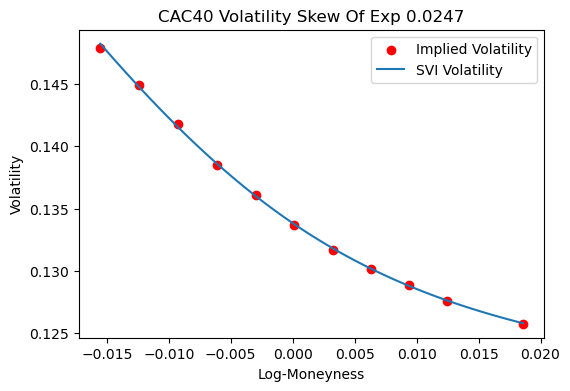

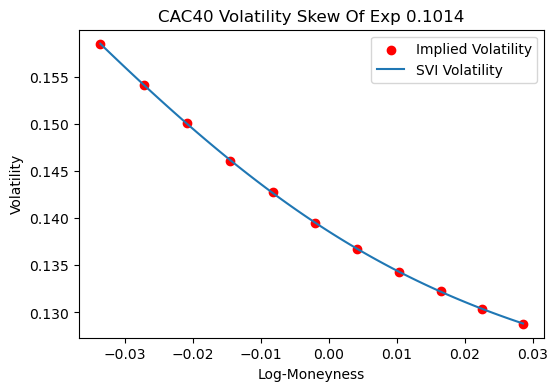

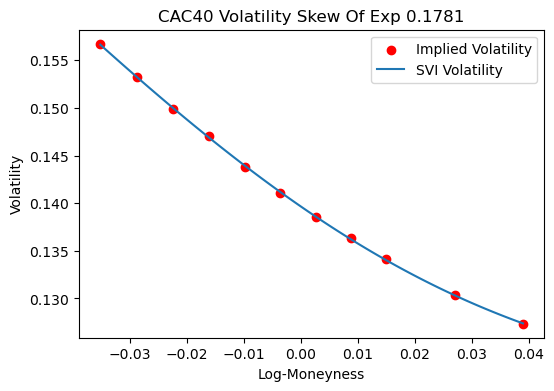

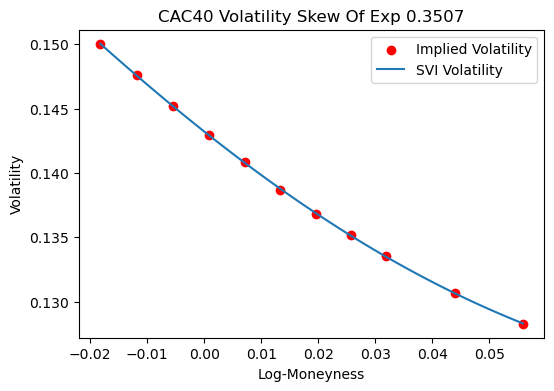

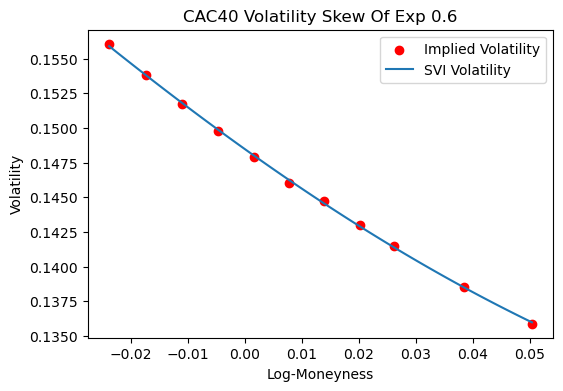

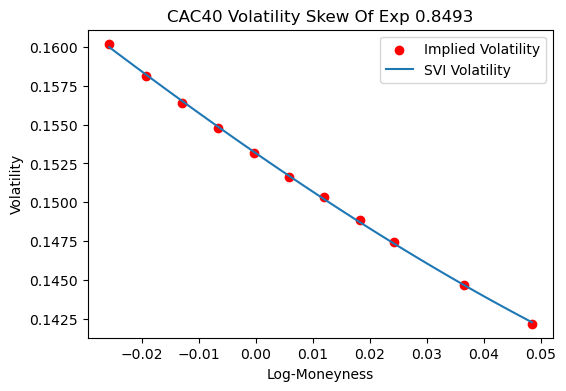

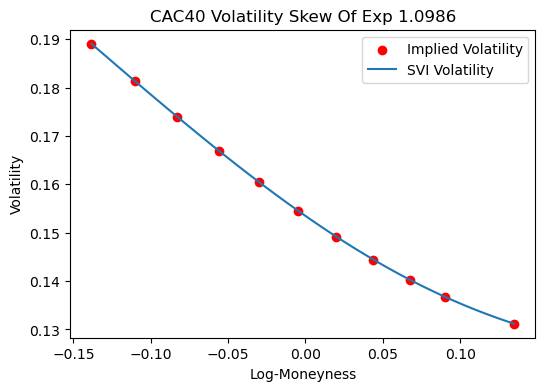

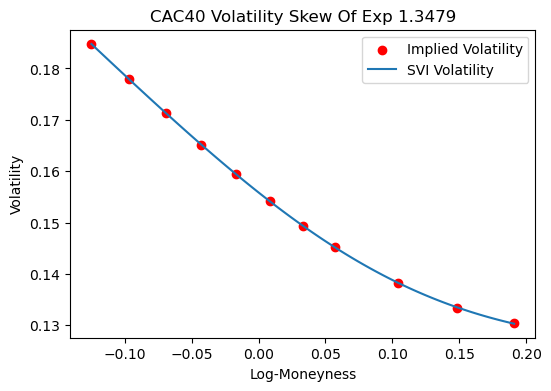

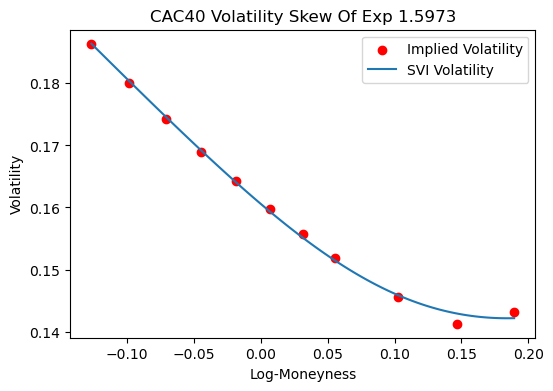

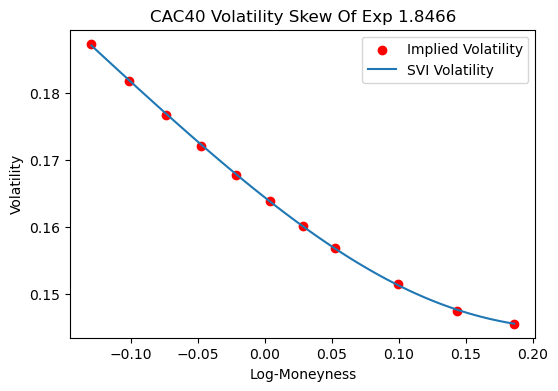

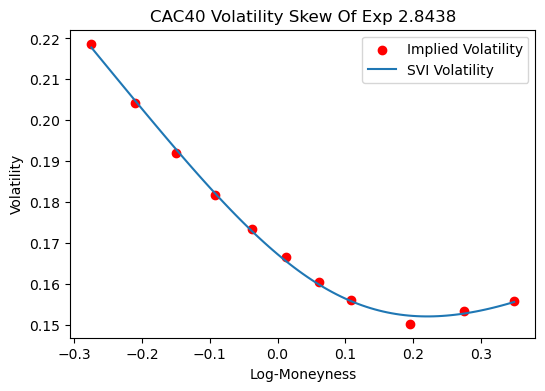

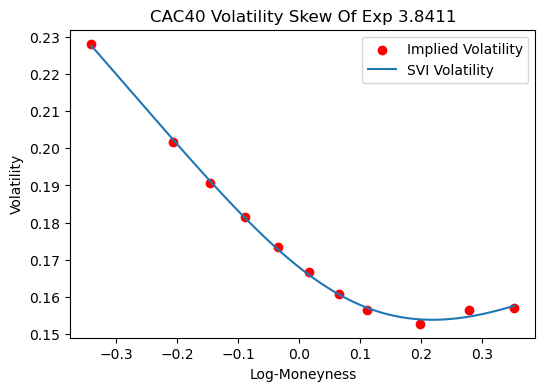

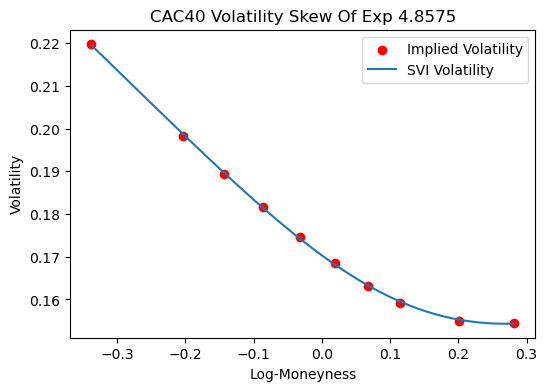

In [4]:
svi_model = SVIModel()
svi_model.params_calibration(listed_expiries, market_log_moneyness, implied_v2Ts)
svi_params = svi_model.params
svi_expiries = list(svi_params.keys())

plt.rcParams["figure.figsize"] = (6,4)

# Filtered Implied v2T(T, k)
market_log_moneyness = [np.log(np.array(market_strikes[exp]) / implied_forwards[exp]) for exp in svi_expiries]
implied_v2Ts = [np.array(implied_vols[exp])**2 * exp for exp in svi_expiries]

for i in range(len(svi_expiries)):
    exp = svi_expiries[i]
    plt.title(eq_underlying + " Volatility Skew Of Exp " + str(round(exp, 4)))
    plt.ylabel("Volatility")
    plt.xlabel("Log-Moneyness") 
    plt.scatter(market_log_moneyness[i], np.sqrt(implied_v2Ts[i] / exp), color="red", label="Implied Volatility")
    x_axis = np.linspace(market_log_moneyness[i][0], market_log_moneyness[i][-1], 101, endpoint=True)
    svi_v2T = [np.sqrt(svi_model.get_v2T(exp, k) / exp) for k in x_axis]
    plt.plot(x_axis, svi_v2T, label="SVI Volatility")
    plt.legend(loc="upper right")
    plt.show()

Finally, we construct the SVI implied volatility and total variance surfaces:

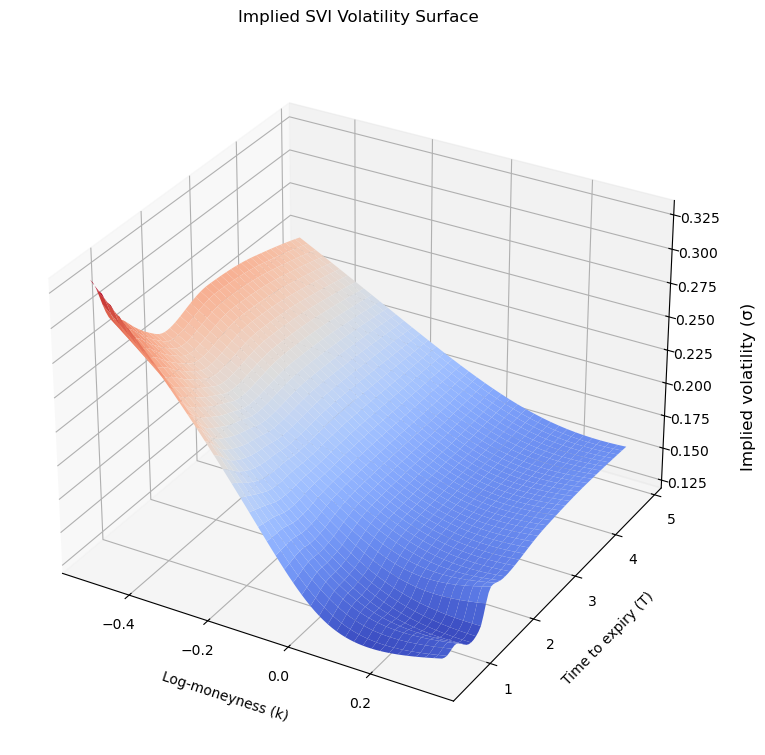

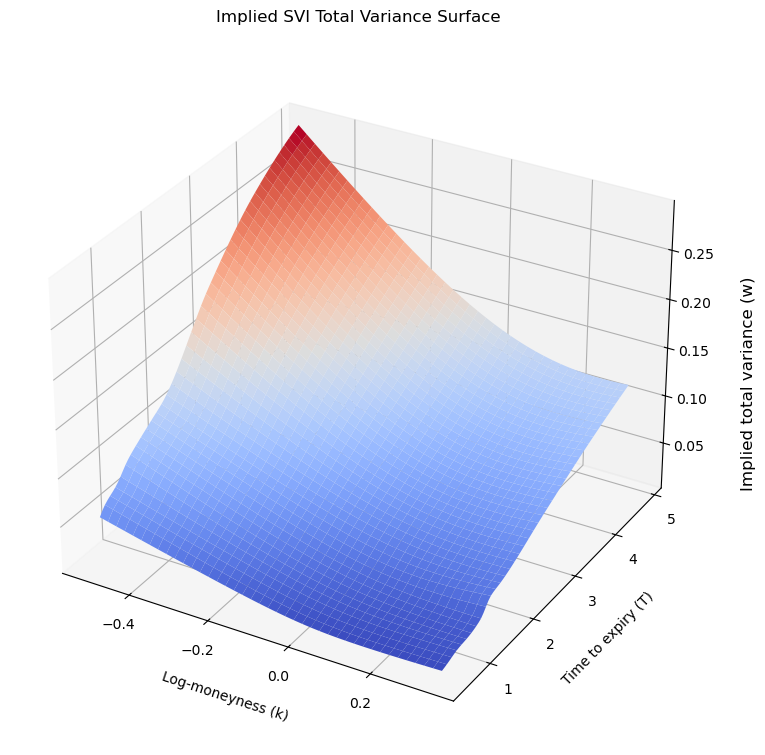

In [5]:
plt.rcParams["figure.figsize"] = (11,8)
svi_model.plot_svi_surface()
svi_model.plot_svi_surface(total_var=True)